## SHAP values analysis

## Imports

In [76]:
from pandas import DataFrame
from standardizer.CustomStandardizer import CustomStandardizer

from rdkit.Chem import MolFromSmiles
import random

from featureImportance.shapValues import ShapValues
from matplotlib.colors import ColorConverter
from rdkit.Chem import Draw
import joblib
from Datasets.Datasets import NumpyDataset
import json
import numpy as np


import pandas as pd

from utils import utils

from loaders.Loaders import CSVLoader

import os
from compoundFeaturization.rdkitFingerprints import MorganFingerprint

from pathlib import Path
import shap
from numpy import genfromtxt

from rdkit.ML.Descriptors import MoleculeDescriptors

from copy import copy

dir_path = Path().absolute()




### Sweeteners preparation

In [2]:
carbohydrates = [
              ["beta-D-Xylopyranose", "C1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O", 1],
              ["beta-D-Fructopyranose", "C1[C@H]([C@H]([C@@H]([C@](O1)(CO)O)O)O)O", 1],
              ["beta-D-Glucopyranose", "C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O", 1],
              ["alpha-D-Glucopyranose", "C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O)O", 1],
              ["alpha-D-Galactose", "C([C@@H]1[C@@H]([C@@H]([C@H]([C@H](O1)O)O)O)O)O", 1],
              ["Maltitol", "C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O[C@H]([C@@H](CO)O)[C@@H]([C@H](CO)O)O)O)O)O)O", 1], 
              ["Lactitol", "C([C@@H]1[C@@H]([C@@H]([C@H]([C@@H](O1)O[C@H]([C@@H](CO)O)[C@@H]([C@H](CO)O)O)O)O)O)O", 1] ,
              ["cellobitol", "C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O[C@H]([C@@H](CO)O)[C@@H]([C@H](CO)O)O)O)O)O)O", 1],
              ["cyclamate", "C1CCC(CC1)NS(=O)(=O)O", 1],
              ["5-Nitro-2-propoxyaniline", "CCCOC1=C(C=C(C=C1)[N+](=O)[O-])N", 1],
              ["6-chloro-D-tryptophan","CCCOC1=C(C=C(C=C1)[N+](=O)[O-])N",1],
              ["alitame", "C[C@H](C(=O)NC1C(SC1(C)C)(C)C)NC(=O)[C@H](CC(=O)O)N", 1],
              ["aspartame", "COC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](CC(=O)O)N", 1],
              ["neotame", "CC(C)(C)CCN[C@@H](CC(=O)O)C(=O)N[C@@H](CC1=CC=CC=C1)C(=O)OC", 1],
              ["saccharin", "C1=CC=C2C(=C1)C(=O)NS2(=O)=O", 1],
              ["dulcin", "CCOC1=CC=C(C=C1)NC(=O)N", 1],
]

carbohydrates = [i[1] for i in carbohydrates]

In [3]:


def get_mols_from_csv(input_file, structure_field):
    
    df = pd.read_csv(input_file)
    
    structures = df.loc[:,structure_field]
    
    return structures

In [4]:
def highlight_atoms_with_query(lst,smarts):
    to_highlight = []
    for mol in lst:
        mol = MolFromSmiles(mol)
        final_tuple = ()
        lst_idx = mol.GetSubstructMatches(smarts)
        for idx in lst_idx:
            final_tuple = final_tuple + idx


        to_highlight.append(final_tuple)
    return to_highlight


In [5]:
bitter_mols = get_mols_from_csv("../resources/data/clean_bitter_molecules.csv", "mols")

In [6]:


def run_shap_values_on_molecules(dataset, model, max_evals, columns_names):
    
    X = pd.DataFrame(dataset.X, columns=columns_names)

    model = model.model
    
    explainer = shap.explainers.Permutation(model.predict, X)
    shap_values = explainer(X, max_evals=max_evals)
    
    return shap_values
    
def get_features_to_keep(model_path, fs_config_file_path):
    
    if "all" in model_path:
        feature_selection = "none"
        if "2d" in model_path:
            features_to_keep = [i for i in range(208)]
        else:
            features_to_keep = [i for i in range(2048)]


    elif "KbestFS" in model_path:
        feature_selection = "KbestFS"
        f = open(fs_config_file_path,)

        data = json.load(f)

        features_to_keep = sorted(data["KbestFS"])

    elif "SelectFromModelFS" in model_path:
        feature_selection = "SelectFromModelFS"
        f = open(fs_config_file_path,)

        data = json.load(f)

        features_to_keep = sorted(data["SelectFromModelFS"])
        
    elif "Boruta" in model_path:
        feature_selection = "Boruta"
        f = open(fs_config_file_path,)

        data = json.load(f)

        features_to_keep = sorted(data["Boruta"])
        
    if "2d" in model_path:
        calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
        features_names = calc.GetDescriptorNames()
        features_names = [features_names[i] for i in features_to_keep]
    
    else:
        features_names = [f"bit {i}" for i in features_to_keep]
        
    return features_to_keep,features_names

In [7]:
def get_feature_and_ecfp4_draw(features_number, molecule):
    
    return utils.draw_morgan_bit_on_molecule(molecule, features_number, chiral=True)

        

In [48]:
def generate_conformers_and_calculate_distances(mol, it, atom_pairs):
    
    atom_pairs_result = {}
    for i,j in atom_pairs:
        results = np.empty(it)
        for k in range(it):
            m2, res, rmslist = get_conformers(mol, nConfGen=20,pruneRmsThreshVal=1)
            conf = m2.GetConformer()
            at1Coords = np.array(conf.GetAtomPosition(i))
            at2Coords = np.array(conf.GetAtomPosition(j))
            results[k] = np.linalg.norm(at2Coords - at1Coords)
            
        average = np.mean(results)
        std = np.std(results)
        atom_pairs_result[str(i) + "_" + str(j)] = (average,std)
    return atom_pairs_result

#### import test datasets

In [9]:


test_dataset = os.path.join("../resources/models", "test_dataset.csv")

loader = CSVLoader(test_dataset,
                       mols_field='mols',
                       labels_fields='y')

test_dataset = loader.create_dataset()

dataset_sweeteners = test_dataset.mols[test_dataset.y == 1]
dataset_non_sweeteners = test_dataset.mols[test_dataset.y == 0]

train_dataset = os.path.join("../resources/models", "train_dataset.csv")

loader = CSVLoader(train_dataset,
                       mols_field='mols',
                       labels_fields='y')

train_dataset = loader.create_dataset()



#### get bitter molecules

In [10]:
from rdkit.Chem import AllChem
from rdkit import DataStructs

bitter_molecules = []
for i, bitter_mol in enumerate(bitter_mols):
    bitter_mol = MolFromSmiles(bitter_mol)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(bitter_mol,2)
    for smiles2 in dataset_non_sweeteners:
        mol2 = MolFromSmiles(smiles2)
        fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2,2)
        similarity = DataStructs.FingerprintSimilarity(fp1,fp2)
        if similarity == 1 and smiles2 not in bitter_molecules:
            bitter_molecules.append(mol2)
            break
            
    if len(bitter_molecules) == 40:
        break

In [11]:
bitter_molecules_sample = random.choices(bitter_mols, k=16)

In [46]:
sweeteners_dataset = NumpyDataset(mols = carbohydrates, ids=np.array([i for i in range(len(carbohydrates))]), y=np.array([1]*len(carbohydrates)))
bitter_dataset = NumpyDataset(mols = bitter_molecules_sample, ids=np.array([i for i in range(len(bitter_molecules_sample))]), y=np.array([0]*len(carbohydrates)))
dataset_to_test = sweeteners_dataset.merge([bitter_dataset])

In [47]:
from rdkit import Chem
from rdkit.Chem import AllChem

def get_conformers(mol, nConfGen=20,pruneRmsThreshVal=1):
    i=0


    m2=Chem.AddHs(mol)
    AllChem.EmbedMultipleConfs(m2,
                                    numConfs=nConfGen, 
                                    pruneRmsThresh=pruneRmsThreshVal,
                                    ignoreSmoothingFailures=True,
                                    numThreads=0)
    res =AllChem.MMFFOptimizeMoleculeConfs(m2, 
                                            maxIters=2000, 
                                            numThreads=0) 
    rmslist = []
    AllChem.AlignMolConformers(m2, RMSlist=rmslist)
    return m2, res, rmslist

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

### ECFP4 - SVM - SHAP analysis - WARNING - Run only if you want to repeat the SHAP process, if you just want to reproduce the work herein delivered, skip to the next section

In [49]:
dataset_to_test_path = os.path.join("../resources","SHAP_analysis/ecfp4_svm/set.csv")
df = pd.read_csv(dataset_to_test)
features = df.columns[3:]
loader = CSVLoader(dataset_to_test_path,
                   features_fields=list(features),
                       mols_field='mols',
                       labels_fields='y')

dataset_to_test = loader.create_dataset()

Mols_shape:  27
Features_shape:  (27, 2048)
Labels_shape:  (27,)


In [31]:


model_path = os.path.join("../resources/models", "ecfp4", "all_svm_model")
model = joblib.load(model_path)

standardisation_params = {
        'REMOVE_ISOTOPE': True,
        'NEUTRALISE_CHARGE': True,
        'REMOVE_STEREO': False,
        'KEEP_BIGGEST': True,
        'ADD_HYDROGEN': False,
        'KEKULIZE': True,
        'NEUTRALISE_CHARGE_LATE': True}

CustomStandardizer(params = standardisation_params).standardize(dataset_to_test)

MorganFingerprint(chiral=True).featurize(dataset_to_test)

fs_config_file_path = os.path.join(dir_path,"stratified_split/", "ecfp4", "feature_selection_config.json")

features_to_keep, feature_names = get_features_to_keep(model_path,fs_config_file_path)
dataset_to_test.select_features(features_to_keep)
print(len(features_to_keep))

shap_values_structures = run_shap_values_on_molecules(dataset_to_test, model, max_evals=10000, columns_names=feature_names)


Standardizing datapoint 0
Featurizing datapoint 0
2048


X has feature names, but SVC was fitted without feature names


KeyboardInterrupt: 

### Save the results only if you had run the previous cell

In [711]:
np.savetxt("SHAP_analysis/ecfp4_svm/shap_values.csv", shap_values_structures.values, delimiter=",")
np.savetxt("SHAP_analysis/ecfp4_svm/base_values.csv", shap_values_structures.base_values, delimiter=",")
np.savetxt("SHAP_analysis/ecfp4_svm/data.csv", shap_values_structures.data, delimiter=",")
dataset_to_test.save_to_csv("SHAP_analysis/ecfp4_svm/set.csv")

## Load results and analyse

In [50]:

model_path = os.path.join("../resources/models", "ecfp4", "all_svm_model")
model = joblib.load(model_path)

standardisation_params = {
        'REMOVE_ISOTOPE': True,
        'NEUTRALISE_CHARGE': True,
        'REMOVE_STEREO': False,
        'KEEP_BIGGEST': True,
        'ADD_HYDROGEN': False,
        'KEKULIZE': True,
        'NEUTRALISE_CHARGE_LATE': True}

CustomStandardizer(params = standardisation_params).standardize(dataset_to_test)

MorganFingerprint(chiral=True).featurize(dataset_to_test)

placeholder_dataset = copy(dataset_to_test)
placeholder_dataset.select([1,16])

explainer = shap.explainers.Permutation(model.model.predict_proba, placeholder_dataset.X)
shap_values_structures = explainer(placeholder_dataset.X)
values = genfromtxt("../resources/SHAP_analysis/ecfp4_svm/shap_values.csv", delimiter=',')
base_values = genfromtxt("../resources/SHAP_analysis/ecfp4_svm/base_values.csv", delimiter=',')
data = genfromtxt("../resources/SHAP_analysis/ecfp4_svm/data.csv", delimiter=',')

Standardizing datapoint 0
Featurizing datapoint 0


RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:28:50] Running Uncharger
RDKit INFO: [14:

In [64]:

shap_values_structures.values=values
shap_values_structures.base_values=list(base_values)
shap_values_structures.data=data

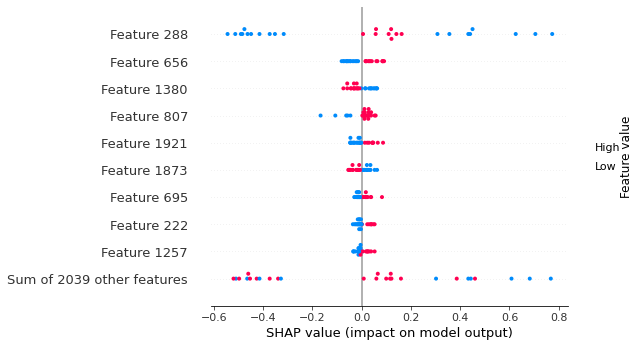

In [52]:
shap.plots.beeswarm(shap_values_structures)

In [242]:
os.makedirs("SHAP_analysis/ecfp4_svm/", exist_ok=True)
dataset_to_test.save_to_csv("SHAP_analysis/ecfp4_svm/set.csv")

## Cyclamate - the first case study

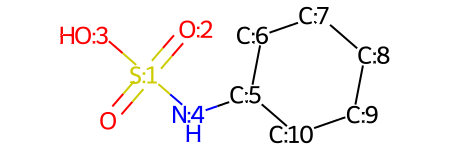

In [53]:
mol_index = 8
mol_with_atom_index(MolFromSmiles(dataset_to_test.mols[mol_index]))

### Get the active bits

In [66]:
bits = []
for i,bit in enumerate(dataset_to_test.X[mol_index]):
    if bit == 1:
        bits.append(i)
        
print(bits)

[2, 92, 350, 428, 455, 592, 650, 807, 890, 911, 926, 1019, 1028, 1152, 1325, 1461, 1476, 1630, 1634]


## X hydrophobic part of AH-B-X theory

Bit 890 with 2 hits!


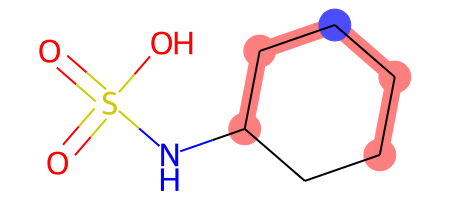

In [67]:
get_feature_and_ecfp4_draw(890, dataset_to_test.mols[mol_index])

Bit 2 with 1 hits!


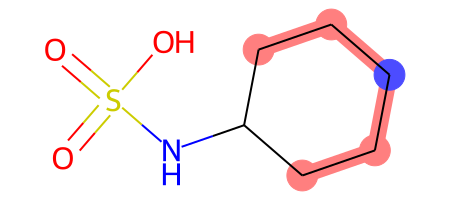

In [68]:
get_feature_and_ecfp4_draw(2, dataset_to_test.mols[mol_index])

In [ ]:
x = [2,890]

cumulative_shap = 0

for bit in x:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
print(f"The cumulative SHAP value for the X structure was: {cumulative_shap}.")

## B part of AH-B-X theory

Bit 807 with 1 hits!


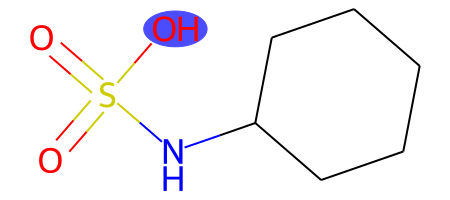

In [71]:
get_feature_and_ecfp4_draw(807, dataset_to_test.mols[mol_index])

In [ ]:
b = [807]

cumulative_shap = 0

for bit in b:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
print(f"The cumulative SHAP value for the B structure was: {cumulative_shap}.")

## AH part of AH-B-X theory

Bit 1152 with 1 hits!


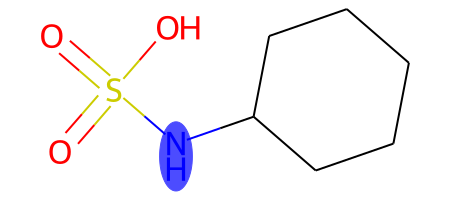

In [74]:
get_feature_and_ecfp4_draw(1152, dataset_to_test.mols[mol_index])

In [75]:
ah = [1152]

cumulative_shap = 0

for bit in ah:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
print(f"The cumulative SHAP value for the AH structure was: {cumulative_shap}.")

The cumulative SHAP value for the AH structure was: 0.015669515669515677.


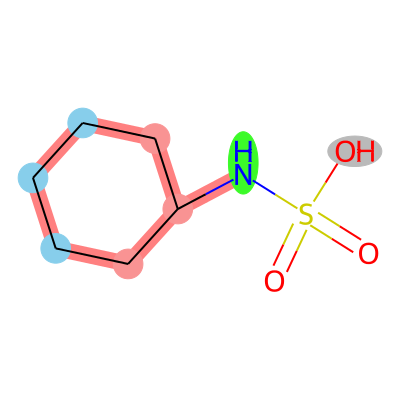

In [77]:

colors = {}

red = [6,5,10]
center_x = [7,8,9]
center_ah = [4]
center_b = [3]

for bit in red:
    colors[bit] = ColorConverter().to_rgb('#f99393')
    
for bit in center_x:
    colors[bit] = ColorConverter().to_rgb('skyblue')
    
for bit in center_b:
    colors[bit] = ColorConverter().to_rgb('#bababa')

for bit in center_ah:
    colors[bit] = ColorConverter().to_rgb('#3cfa29')
    
mol = MolFromSmiles(dataset_to_test.mols[mol_index])
m2, res, rmslist = get_conformers(mol, nConfGen=20,pruneRmsThreshVal=1)
AllChem.Compute2DCoords(m2)
m2 = Chem.RemoveHs(m2)

Draw.MolsToGridImage([m2],highlightAtomLists=[colors.keys()],
                     highlightAtomColors=[colors], molsPerRow=1, subImgSize=(400,400))

### Get the atom distance between the AH and B eletronegative atoms

In [78]:
atom_pairs = [(7,5)]
atom_pairs_result = generate_conformers_and_calculate_distances(MolFromSmiles(dataset_to_test.mols[mol_index]), 50, atom_pairs)

In [79]:
print(f"The average and standard deviation of the distance between AH and B are {atom_pairs_result['7_5'][0]} and {atom_pairs_result['7_5'][1]}")

The average and standard deviation of the distance between AH and B are 2.542419857064859 and 0.014004046447130603


## 1-n-propoxy-2-am ino-4-nitrobenzene (4000x) - second case study

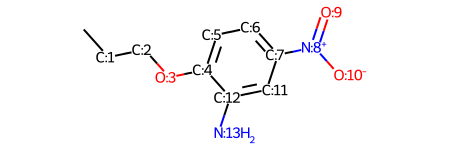

In [82]:
mol_index = 9
mol_with_atom_index(MolFromSmiles(dataset_to_test.mols[mol_index]))

### B structure of AH-B theory

Bit 715 with 1 hits!


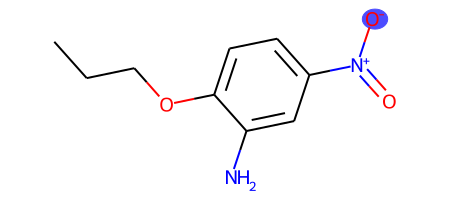

In [84]:
get_feature_and_ecfp4_draw(715, dataset_to_test.mols[mol_index])

In [83]:
b = [715]

cumulative_shap = 0

for bit in b:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
print(f"The cumulative SHAP value for the B structure was: {cumulative_shap}.")

The cumulative SHAP value for the B structure was: 0.0754985754985755.


### AH substructure of AH-B theory

Bit 1750 with 2 hits!


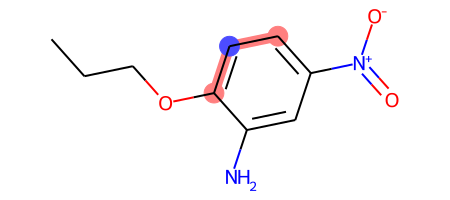

In [85]:
get_feature_and_ecfp4_draw(1750, dataset_to_test.mols[mol_index])

In [86]:
ah = [1750]

cumulative_shap = 0

for bit in ah:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
print(f"The cumulative SHAP value for the B structure was: {cumulative_shap}.")

The cumulative SHAP value for the B structure was: 0.0071225071225071174.


### The whole structure of AH-B

Bit 1809 with 1 hits!


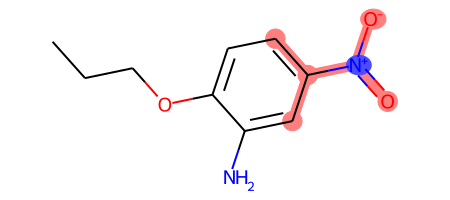

In [87]:
get_feature_and_ecfp4_draw(1809, dataset_to_test.mols[mol_index])

In [89]:
print(f"The cumulative SHAP value for the whole AH-B structure was: {shap_values_structures.values[mol_index][1809]}.")

The cumulative SHAP value for the whole AH-B structure was: 0.09259259259259257.


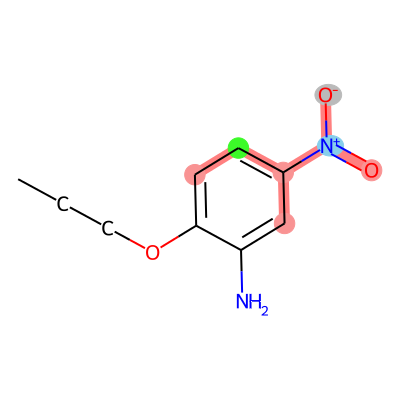

In [90]:
from matplotlib.colors import ColorConverter
colors = {}

red = [7,11,9, 5]
center_whole = [8]
center_ah = [6]
center_b = [10]

for bit in red:
    colors[bit] = ColorConverter().to_rgb('#f99393')
    
for bit in center_whole:
    colors[bit] = ColorConverter().to_rgb('skyblue')
    
for bit in center_b:
    colors[bit] = ColorConverter().to_rgb('#bababa')

for bit in center_ah:
    colors[bit] = ColorConverter().to_rgb('#3cfa29')
    
mol = MolFromSmiles(dataset_to_test.mols[mol_index])
m2, res, rmslist = get_conformers(MolFromSmiles(dataset_to_test.mols[mol_index]), nConfGen=20,pruneRmsThreshVal=1)
AllChem.Compute2DCoords(m2)
m2 = Chem.RemoveHs(m2)

Draw.MolsToGridImage([m2],highlightAtomLists=[colors.keys()],
                     highlightAtomColors=[colors], molsPerRow=1, subImgSize=(400,400))

In [93]:
atom_pairs = [(10,6)]
atom_pairs_result = generate_conformers_and_calculate_distances(MolFromSmiles(dataset_to_test.mols[mol_index]), 50, atom_pairs)

In [94]:
print(f"The average and standard deviation of the distance between AH and B are {atom_pairs_result['10_6'][0]} and {atom_pairs_result['10_6'][1]}")

The average and standard deviation of the distance between AH and B are 3.2125006117054444 and 0.41890770010990663


## β-D-Glucopyranose - third case study

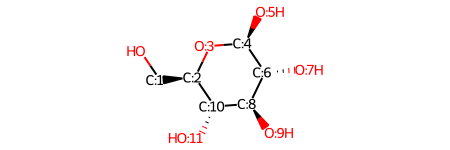

In [95]:
mol_index = 2
mol_with_atom_index(MolFromSmiles(dataset_to_test.mols[mol_index]))

Bit 1257 with 4 hits!


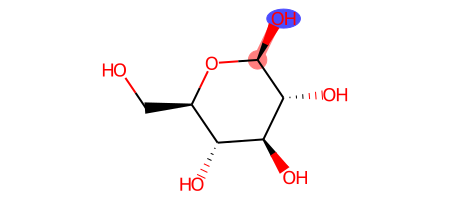

In [96]:
get_feature_and_ecfp4_draw(1257, dataset_to_test.mols[mol_index])

Bit 807 with 5 hits!


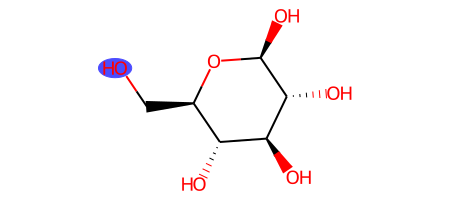

In [98]:
get_feature_and_ecfp4_draw(807, dataset_to_test.mols[mol_index])

In [99]:
bits = [807,1257]

cumulative_shap = 0

for bit in bits:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
print(f"The cumulative SHAP value for the whole AH-B structure was: {cumulative_shap}.")

The cumulative SHAP value for the whole AH-B structure was: 0.06980056980056981.


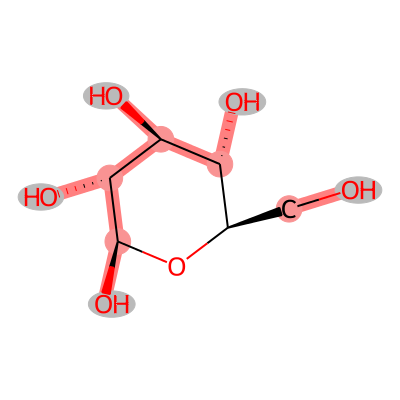

In [100]:
from rdkit.Chem import Draw

colors = {}

red = [4,6,8,10,1]
center_whole = [7,11,9,5,0]

for bit in center_whole:
    colors[bit] = ColorConverter().to_rgb('#bababa')
    
for bit in red:
    colors[bit] = ColorConverter().to_rgb('#f99393')

    
mol = MolFromSmiles(dataset_to_test.mols[mol_index])
m2, res, rmslist = get_conformers(mol, nConfGen=20,pruneRmsThreshVal=1)
AllChem.Compute2DCoords(m2)
m2 = Chem.RemoveHs(m2)

Draw.MolsToGridImage([m2],highlightAtomLists=[colors.keys()],
                     highlightAtomColors=[colors], molsPerRow=1, subImgSize=(400,400))


In [103]:
atom_pairs = [(7,5), (11,9), (7,9)]
atom_pairs_result = generate_conformers_and_calculate_distances(MolFromSmiles(dataset_to_test.mols[mol_index]), 50, atom_pairs)

#### Distance between hydroxyl groups

In [104]:
atom_pairs_result

{'7_5': (3.129795059809569, 0.3433115413770174),
 '11_9': (2.942048022222105, 0.24400893228601764),
 '7_9': (2.9792008390073415, 0.23221082650201835)}

## Alitame - fourth case study

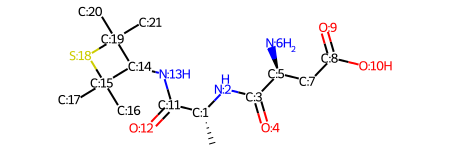

In [105]:
mol_index = 11
mol_with_atom_index(MolFromSmiles(dataset_to_test.mols[mol_index]))

Bit 1565 with 1 hits!


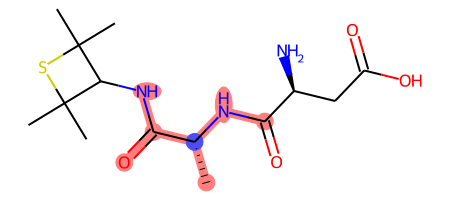

In [110]:
get_feature_and_ecfp4_draw(1565, dataset_to_test.mols[mol_index])

In [111]:
dihedral = [1565]
cumulative_shap = 0

for bit in dihedral:
    cumulative_shap += shap_values_structures.values[mol_index][bit]
print(f"The cumulative SHAP value for the whole dihedral angle theory substructure was: {cumulative_shap}.")

The cumulative SHAP value for the whole dihedral angle theory substructure was: 0.01566951566951567.


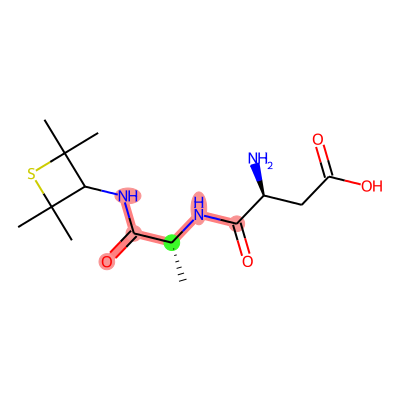

In [112]:
colors = {}

red = [2,3,11,12,13]
center_whole = [8]
center_dihedral = [1]

for bit in red:
    colors[bit] = ColorConverter().to_rgb('#f99393')

for bit in center_dihedral:
    colors[bit] = ColorConverter().to_rgb('#3cfa29')

mol = MolFromSmiles(dataset_to_test.mols[mol_index])

Draw.MolsToGridImage([mol],highlightAtomLists=[colors.keys()],
                     highlightAtomColors=[colors], molsPerRow=1, subImgSize=(400,400))